# Part 2: Dynamic Spin Structure Factor 

ATTENTION: Changed stuff at the end (regarding the time evolution) -> Might produce different results now

In [1]:
import a_mps, b_model, c_tebd
import numpy as np
import importlib
import matplotlib.pyplot as plt

In [7]:
importlib.reload(a_mps)
importlib.reload(b_model)
importlib.reload(c_tebd)

<module 'c_tebd' from 'c:\\Users\\work\\OneDrive - TUM\\Dokumente\\Studium\\QST MSc\\FoPra\\FoPra 32\\c_tebd.py'>

## Part a)

- Use the TEBD algorithm to write some code that performs a time evolution and calculates correlation functions of the form $C(t, j) = <\psi_0| e^{i H t} \sigma_j^y e^{-i H t} \sigma^y_{L/2}|\psi_0>$, where $|\psi_0>$ is the ground state of the transverse field Ising model. 
- During the time evolution, make sure to save the bipartite von-Neumann entanglement entropy $S(t) = −\sum_\alpha \Lambda_a^2(t) ln(\Lambda_\alpha^2(t))$, where $\Lambda_\alpha$ are the Schmidt values on the bond at the center of the time evolved state $|\psi(t)> = $e^{−iHt}\sigma^y_{L/2} |\psi_0>$.

In [2]:
sigma_z = np.array([[1, 0], [0, -1]])
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])

In [3]:
def calc_ground_state(L, J, g, h, dt):
    E_0, psi_0, model = c_tebd.example_TEBD_gs_finite(L, J, g, h) # get the ground state and ground state energy
    U_bonds_0 = c_tebd.calc_U_bonds(model, dt)
    return E_0, psi_0, model, U_bonds_0

In [149]:
def calc_time_evolution(t, dt, psi_0, U_bonds_imag, L, J, g, h):
    """Calculate e^-iHt sigma^y_(L/2)|psi_0>"""
    psi_t = psi_0.copy()
    psi_t_y = np.tensordot(sigma_y, psi_t.Bs[int(L//2)], [1, 1]) # i [i*], vL [i] vR
    psi_t.Bs[L//2] = psi_t_y.transpose([1, 0, 2]) # vL i vR
    entropies = [psi_t.entanglement_entropy()]
    psi_ts = [psi_t.copy()]
    for i in range(int(t//dt)):
        c_tebd.run_TEBD(psi = psi_t, U_bonds = U_bonds_imag, N_steps = 1, chi_max = 100, eps = 10**(-6))
        entropies.append(psi_t.entanglement_entropy())
        psi_ts.append(psi_t.copy())
    return psi_ts, entropies

In [44]:
E_0, psi_0, model, U_bonds_0 = calc_ground_state(L = 30, J = 1, g = 0.2, h = 0, dt = 0.01*1j)

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.20, h=0
dt = 0.10000: E = -29.3207349249999
dt = 0.01000: E = -29.3208462293694
dt = 0.00100: E = -29.3208578417311
dt = 0.00010: E = -29.3208590077443
dt = 0.00001: E = -29.3208591243506
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]


In [45]:
psi_ts, entropies = calc_time_evolution(t = 25, dt = 0.01, psi_0 = psi_0, U_bonds_0 = U_bonds_0, L = 30, J = 1, g = 0.2, h = 0)

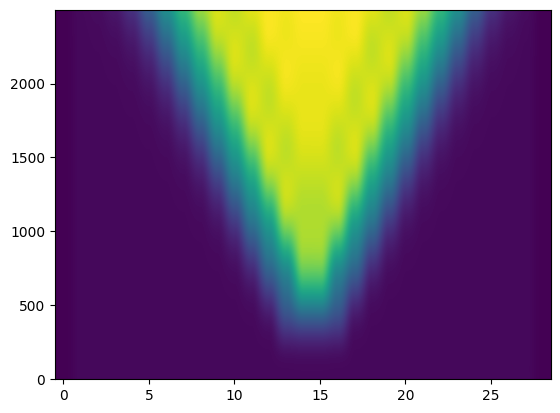

In [46]:
entropies = np.array(entropies)
fig,ax = plt.subplots()
cax = ax.imshow(np.real(entropies), aspect = 'auto')
ax.invert_yaxis()
plt.show()

In [47]:
def calc_all_contractions_from_right(psi_1, psi_2, L):
    contractions_from_right = [np.tensordot(psi_1.Bs[L-1], np.conjugate(psi_2.Bs[L-1]), [[1,2], [1,2]])] # vL [i] [vR], vL* [i*] [vR*]
    for j in range(1, L-1):
        right_side = np.tensordot(psi_1.Bs[L-j-1], contractions_from_right[j-1], [2, 0]) # vL i [vR], [vL] vL*
        interm_res = np.tensordot(np.conjugate(psi_2.Bs[L-j-1]), right_side, [[1,2], [1,2]]) # vL* [i*] [vR*], vL [i] [vL*]
        contractions_from_right.append(interm_res.transpose([1,0])) 
    return contractions_from_right

In [48]:
def calc_all_contractions_from_left_op(psi_1, psi_2, L, op):
    contractions_from_left = [np.array([[np.tensordot(psi_1.Ss[0], np.conjugate(psi_2.Ss[0]), [0,0])]])] # [vL] vR, [vL*] vR*
    contractions_from_left_with_op = []
    for j in range(L):
        left_side = np.tensordot(contractions_from_left[j], psi_1.Bs[j], [0,0]) # [vR] vR*, [vL] i vR
        contractions_from_left.append(np.tensordot(left_side, np.conjugate(psi_2.Bs[j]), [[0,1], [0,1]])) # [vR*] [i] vR, [vL*] [i*] vR*
        left_side_op = np.tensordot(left_side, op, [1,1]) # vR* [i] vR, i [i*]
        contractions_from_left_with_op.append(np.tensordot(left_side_op, np.conjugate(psi_2.Bs[j]), [[0,2], [0,1]])) # [vR*] vR [i], [vL*] [i*] vR*
    return contractions_from_left_with_op

In [157]:
def dssf_corr(t, dt, L, J , g, h, psi_0 = None, model = None, E_0 = None, return_entropy = False):
    """Calculate correlation functions of the form <psi_0|e^iHt sigma^y_j e^-iHt sigma^y_(L/2)|psi_0> for all j"""
    if not psi_0 or not model or not E_0:
        E_0, psi_0, model, U_bonds_0 = calc_ground_state(L, J, g, h, dt) # get ground state
    U_bonds_imag = c_tebd.calc_U_bonds(model, 1j*dt)
    psi_ts, entropies = calc_time_evolution(t, dt, psi_0, U_bonds_imag, L, J, g, h)
    C = []
    t_list = dt * np.arange(0, int(t//dt))
    for k in range(len(t_list)):
        psi_t = psi_ts[k]
        t_t = t_list[k]
        c_list = []
        contractions_from_right = calc_all_contractions_from_right(psi_0, psi_t, L)
        contractions_from_left_with_op = calc_all_contractions_from_left_op(psi_0, psi_t, L, sigma_y)
        for j in range(len(contractions_from_right)):
            c_list.append(np.exp(1j*E_0*t_t) * np.tensordot(contractions_from_left_with_op[j], contractions_from_right[-j-1], [[0,1] , [0,1]])) # [vR] [vR*], [vL*] [vL]
        c_list.append(np.trace(contractions_from_left_with_op[-1]))
        C.append(c_list)
    if return_entropy:
        return C, entropies
    return C

In [153]:
test_corr = dssf_corr(t = 25, dt = 0.01, L = 30, J = 1, g = 0.2, h = 0, psi_0 = psi_0, model = model, E_0 = E_0)

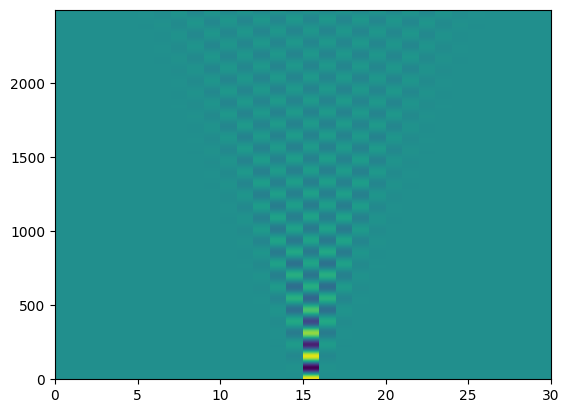

In [62]:
plt.pcolormesh(np.real(np.array(test_corr)))

## Part b)

- Write another function that performs a Fourier transformation in space and time to obtain the dynamic structure factor $S(k, \omega)$:

$$
S(k, \omega) = \sum^{L−1}_{j=0} \sum^N_{t_n = 0}e^{i\omega \delta t \cdot t_n − i k \cdot j} C(\Delta t \cdot t_n, j) · G(tn)
$$


- Remember to multiply the signal with a Gaussian window function G(tn) in order to avoid Gibbs oscillations from the Fourier transform of the finite time data (cf. equation (7)).

In [53]:
def get_spectral_function(corrs, L, dt):
        
    # Rearrange corrs such that position 0 corresponds to the perturbed site
    # (distance 0 to perturbation)
    xi = L//2
    c_temp = np.zeros(corrs.shape, dtype=complex)
    c_temp[:, :L-xi] = corrs[:, xi:]
    c_temp[:, L-xi:] = corrs[:, :xi]
    corrs = c_temp
    
    print('Compute Fourier transform')
    # Fourier transform in space
    corrs_tk = np.zeros((corrs.shape[0], corrs.shape[1]+1), dtype=complex)
    for i in np.arange(corrs.shape[0]):
        momenta, Ck = fourier_space(corrs[i,:])
        corrs_tk[i, :] = Ck
        
    # Fourier transform in time
    Swk = np.zeros(corrs_tk.shape, dtype=complex)
    for k in np.arange(corrs_tk.shape[1]):
        freqs, Sw = fourier_time(corrs_tk[:, k], dt)
        Swk[:, k] = Sw
    print('finished')
    
    return np.array(Swk), momenta, freqs


def fourier_time(t_series, dt, sigma = 0.4):
    """ Calculates the FFT of a time series, applying a Gaussian window function. """
    
    # Gaussian window function
    n = len(t_series)
    gauss = [np.exp(-1/2.*(i/(sigma * n))**2) for i in np.arange(n)]
    input_series = gauss * t_series
    
    # Fourier transform
    ft = np.fft.fft(input_series)
    freqs = np.fft.fftfreq(n, dt) * 2 * np.pi
    
    # order frequencies in increasing order
    end = np.argmin(freqs)
    freqs = np.append(freqs[end:], freqs[:end])
    # shift results accordingly
    ftShifted = np.append(ft[end:], ft[:end])
    
    # Take into account the additional minus sign in the time FT
    if len(ftShifted)%2 == 0:
        ftShifted = np.append(ftShifted, ftShifted[0])
        ftShifted = ftShifted[::-1]
        ftShifted = ftShifted[:-1]
    else:
        ftShifted = ftShifted[::-1]
        
    return freqs, ftShifted


def fourier_space(x_series):
    """ Calculates the FFT of a spatial series of values. """
    import numpy as np
    ft = np.fft.fft(x_series)
    n = len(x_series)
    momenta = 2*np.pi * np.fft.fftfreq(n, 1)
    
    # order momenta in increasing order
    momenta = np.fft.fftshift(momenta)
    
    # shift results accordingly
    Ck = np.fft.fftshift(ft)
    
    # extend the results to the whole Brillouin zone (right border included)
    momenta = np.append(momenta, -momenta[0])
    Ck = np.append(Ck, Ck[0])
    
    return momenta, Ck

In [63]:
ft = get_spectral_function(np.array(test_corr), 30, 0.01)

Compute Fourier transform
finished


(0.0, 7.0)

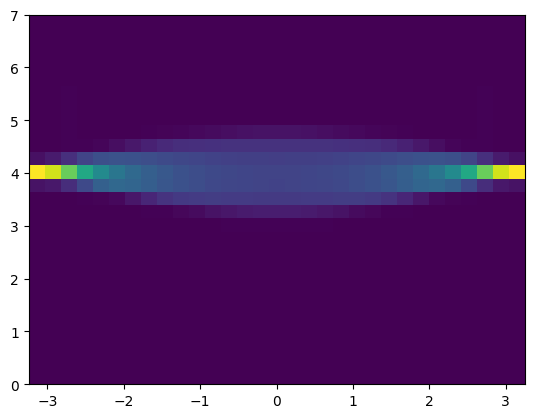

In [70]:
plt.pcolormesh(ft[1], -1*ft[2], np.real(ft[0]))
plt.ylim(0, 7)

In [143]:
def full_dssf_calc(t, dt, L, J , g, h, return_entropy = False, return_corrs = False):
    corrs, entropies = dssf_corr(t, dt, L, J , g, h, return_entropy=True)
    ft1, ft2, ft3 = get_spectral_function(np.array(corrs), L, dt)
    if return_entropy:
        if return_corrs:
            return (ft1, ft2, ft3), entropies, corrs
        else:
            return (ft1, ft2, ft3), entropies
    else:
        if return_corrs:
            return (ft1, ft2, ft3), corrs
        return ft1, ft2, ft3

## Part c)

- Perform a time evolution at g = 0.2 and g = 2 with h = 0. For this task, we choose the total time T such that the excitation does not spread to the boundary yet. 
- To check this, plot the correlations C(t, j) as a colorplot in dependence of time and the spatial variable j. Make a similar plot for the bipartite von Neumann entanglement entropy S(t). What do you observe?

Hint: You can choose for instance L = 30, T = 25 J and L = 50, T = 10 J for the cases g = 0.2 and g = 2 respectively.

- Obtain S(k, $\omega$) from C(t, j) using your code from part (b). How do the spectral functions in the two cases compare?
- Feel free to play around with the parameters of the simulation such as system size L, total simulation time T and time step size $\Delta t$ to improve the quality of your plots.

In [158]:
# g = 2
dssf_2, entropies_2, corrs_2 = full_dssf_calc(t = 10, dt = 0.01, L = 50, J = 1, g = 2, h = 0, return_entropy = True, return_corrs = True)

finite TEBD, (imaginary time evolution)
L=50, J=1.0, g=2.00, h=0
dt = 0.10000: E = -105.7113662726242
dt = 0.01000: E = -106.1727069458336
dt = 0.00100: E = -106.2178652998994
dt = 0.00010: E = -106.2223598067640
dt = 0.00001: E = -106.2228096272322
final bond dimensions:  [2, 4, 8, 12, 14, 14, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 14, 14, 12, 8, 4, 2]
Compute Fourier transform
finished


(200.0, 220.0)

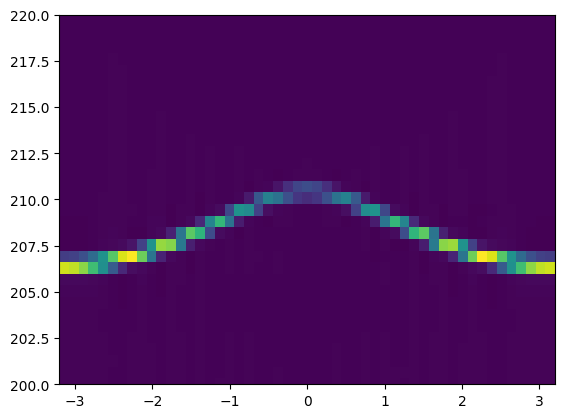

In [161]:
plt.pcolormesh(dssf_2[1], dssf_2[2], np.real(dssf_2[0]))
plt.ylim(200,220)

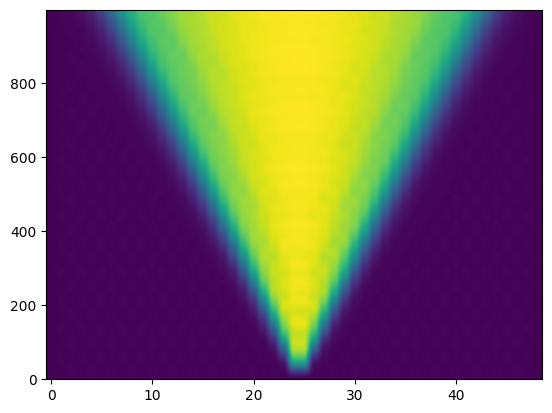

In [162]:
entropies_2_arr = np.array(entropies_2)
fig,ax = plt.subplots()
cax = ax.imshow(np.real(entropies_2_arr), aspect = 'auto')
ax.invert_yaxis()
plt.show()

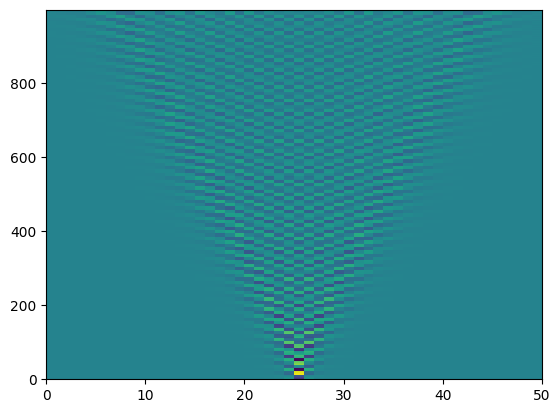

In [163]:
plt.pcolormesh(np.real(np.array(corrs_2)))

In [136]:
# g = 0.2
dssf_1, entropies_1, corrs_1 = full_dssf_calc(t = 25, dt = 0.01, L = 30, J = 1, g = 0.2, h = 0, return_entropy = True, return_corrs = True)

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.20, h=0
dt = 0.10000: E = -29.3207349249999
dt = 0.01000: E = -29.3208462293694
dt = 0.00100: E = -29.3208578417311
dt = 0.00010: E = -29.3208590077443
dt = 0.00001: E = -29.3208591243506
final bond dimensions:  [2, 4, 8, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 8, 4, 2]
Compute Fourier transform
finished


(20.0, 40.0)

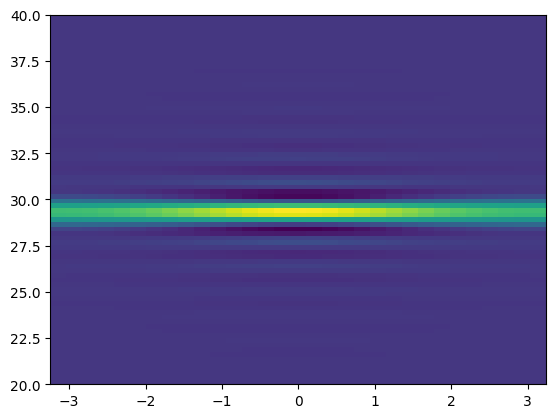

In [106]:
plt.pcolormesh(dssf_1[1], -1*dssf_1[2], np.real(dssf_1[0]))
plt.ylim(20, 40)

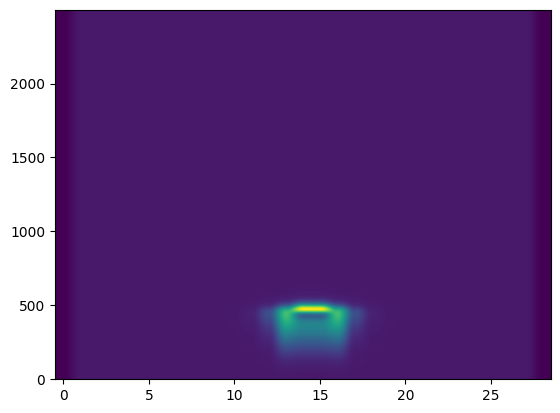

In [140]:
entropies_1_arr = np.array(entropies_1)
fig,ax = plt.subplots()
cax = ax.imshow(np.real(entropies_1_arr), aspect = 'auto')
ax.invert_yaxis()
plt.show()

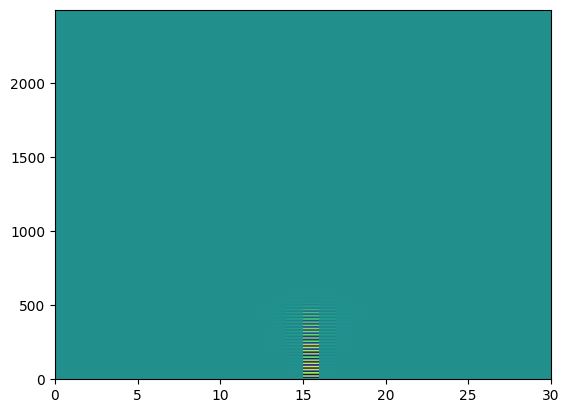

In [138]:
plt.pcolormesh(np.real(np.array(corrs_1)))

## Part d)

- Obtain S(k, $\omega$) at g = 0.2 and h = 0.1. How does the picture change compared to (c)? 

At low transverse field and small bound state momentum, the system can be described by a one-dimensional Schrödinger equation with a linear confining potential with the energy levels given by the negative zeros of the Airy function.
- Compare the bound states you find in your numerics with the zeros of the Airy
function.

In [117]:
# g = 0.2, h = 0.1
dssf_3 = full_dssf_calc(t = 25, dt = 0.01, L = 30, J = 1, g = 0.2, h = 0.1)

finite TEBD, (imaginary time evolution)
L=30, J=1.0, g=0.20, h=0.1
dt = 0.10000: E = -32.3034949222838
dt = 0.01000: E = -32.3035779409171
dt = 0.00100: E = -32.3035866244865
dt = 0.00010: E = -32.3035874964951
dt = 0.00001: E = -32.3035875837022
final bond dimensions:  [2, 4, 6, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 4, 2]
Compute Fourier transform
finished


(20.0, 40.0)

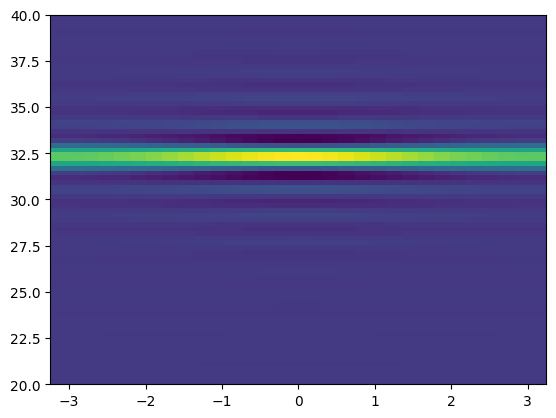

In [118]:
plt.pcolormesh(dssf_3[1], -1*dssf_3[2], np.real(dssf_3[0]))
plt.ylim(20, 40)